In [1]:
import os
import json
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import optimize
import math

from process_opendata import athlete, pre_process, performance_fxns

In [135]:
sample_open_data_ath = "E:\gc_opendata\9787e81f-19f6-4cc1-891d-63e68b4d2f9f"
ath_dirs = ['/Users/ryanduecker/git/athletics/TriNet/gc_opendata-samples/618af747-d5d6-45e1-9efc-aaa1dd2d6cf0'
,'/Users/ryanduecker/git/athletics/TriNet/gc_opendata-samples/2eb4fb29-df91-4a3c-89b3-5e94d21abbb5'
,'/Users/ryanduecker/git/athletics/TriNet/gc_opendata-samples/17905333-980d-491a-8605-165086df72eb' # no HR
,'/Users/ryanduecker/git/athletics/TriNet/gc_opendata-samples/31687531-a279-4c55-9a20-b552ffbd5d69'
,'/Users/ryanduecker/git/athletics/TriNet/gc_opendata-samples/62752551-b668-4bba-8d50-48bebc4ddf15'
]
sample_open_data_ath = ath_dirs[3]

In [136]:
ath0 = athlete(root_dir=sample_open_data_ath)
ath0.get_activity_metadata()


'Metadata processed'

In [137]:
## LOADS INDIVIDUAL ACTIVITIES 

# max_array = 0
# dim_array = 0
# all_activity_arrays = []
# for activity_filepath in ath0.athlete_activity_filepaths:
#     activity_array = ath0.extract_activity(activity_filepath=activity_filepath, make_xspeed=True)
#     if activity_array.shape[1] > max_array:
#         max_array = activity_array.shape[1]
#     if activity_array.shape[0] > dim_array:
#         dim_array = activity_array.shape[0]
#     activity_datetime_str = os.path.split(activity_filepath)[-1]
#     activity_datetime = datetime.datetime.strptime(activity_datetime_str, '%Y_%m_%d_%H_%M_%S.csv')
#     all_activity_arrays.append({'activity_dt':activity_datetime,'data_array':activity_array})

In [138]:
# metadata_hr_offset = (((ath0.activity_metadata[0]['activity_dt'] - all_activity_arrays[0]['activity_dt']).seconds/60/60) +
#                       ((ath0.activity_metadata[0]['activity_dt'] - all_activity_arrays[0]['activity_dt']).days * 24))
# (ath0.activity_metadata[0]['activity_dt'] - all_activity_arrays[0]['activity_dt']).days

# Focused data explore

In [139]:
with open(ath0.athlete_summary_file,'r') as f:
    ath_sum = f.read()
    f.close()
ath_sum_l = json.loads(ath_sum)

In [140]:
ath_sum_df = pd.json_normalize(ath_sum_l['RIDES'])

In [141]:
ath_sum_df[300:][['sport','METRICS.average_power','METRICS.average_hr','METRICS.a_coggan_tss']]

,sport,METRICS.average_power,METRICS.average_hr,METRICS.a_coggan_tss
300,Bike,NaN,"[130.26881, 2299.00000]",NaN
301,Bike,NaN,"[132.79895, 2467.00000]",NaN
302,Bike,NaN,"[133.18180, 4648.00000]",NaN
303,Bike,NaN,"[121.97809, 2305.00000]",NaN
304,Bike,NaN,"[124.93469, 3353.00000]",NaN
...,...,...,...,...
3010,Bike,"[115.67122, 4316.00000]","[86.55190, 4316.00000]",30.29338
3011,Bike,"[119.90824, 6288.00000]","[124.27545, 6288.00000]",41.23364
3012,Bike,"[120.68868, 3604.00000]","[117.20949, 3604.00000]",23.64708
3013,Bike,"[131.98969, 5429.00000]","[113.38322, 5429.00000]",44.70804


In [142]:
ath_sum_df['sport'] = np.where(ath_sum_df['sport']==''
                            ,np.where(ath_sum_df['METRICS.average_power'] != ''
                            ,'Bike'
                            ,np.where(ath_sum_df['METRICS.pace'] != ''
                                    ,'Run'
                                    ,''))
                        ,ath_sum_df['sport'])

<AxesSubplot:ylabel='Frequency'>

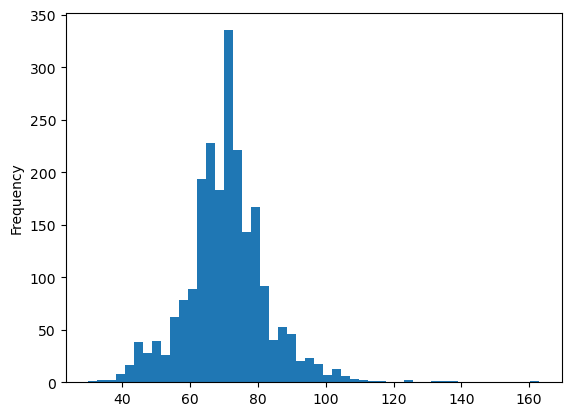

In [143]:
mins = ath_sum_df['METRICS.min_heartrate'].dropna().astype(float)
mins.plot(kind='hist',bins=50)

In [144]:
max_hr = ath_sum_df['METRICS.max_heartrate'].astype(float).dropna().quantile(.99)
rhr = 43

athlete_statics = {'max_hr': max_hr,
                   'resting_hr':rhr}


In [145]:
ath_sum_df['sport'].unique()

array(['Bike', 'Run', 'Workout', 'Hike', 'Walk', 'Kayaking'], dtype=object)

In [146]:
def pull_justx(val):
    try:
        return float(val[0])
    except:
        return np.nan
try:
    ath_sum_df['METRICS.xPace_safe'] = ath_sum_df['METRICS.xPace'].apply(pull_justx)
except:
    ath_sum_df['METRICS.xPace_safe'] = 0
    print('no run activities')

# Modeling
___
## Scipy Solver
### Functions & Data Prep

In [147]:
class banister(object):
    def __init__(self, params=[0.1, 0.5, 50, 45, 7], ctlatl_start=0):
        self.params = params
        self.ctls = []
        self.atls = []
        self.ctlatl_start = [ctlatl_start]
    
    def model(self, load_metric, params=[]):
        if len(params) != 5:
            params = self.params
        self.params = params
        
        self.ctls = self.atls = self.ctlatl_start # why?
        Banister_Predictions = np.array([])
        for i in range(len(load_metric)):
            ctl = (load_metric[i] * (1-math.exp(-1/params[3]))) + (self.ctls[i] * (math.exp(-1/params[3])))
            atl = (load_metric[i] * (1-math.exp(-1/params[4]))) + (self.atls[i] * (math.exp(-1/params[4])))
            self.ctls.append(ctl)
            self.atls.append(atl)
            Banister_Predictions = np.append(Banister_Predictions, params[2] + params[0]*ctl - params[1]*atl)

        return Banister_Predictions

In [148]:
ath_sum_df[ath_sum_df['METRICS.triscore'].astype(float) > 0].shape[0]/ath_sum_df.shape[0]

0.9996683250414594

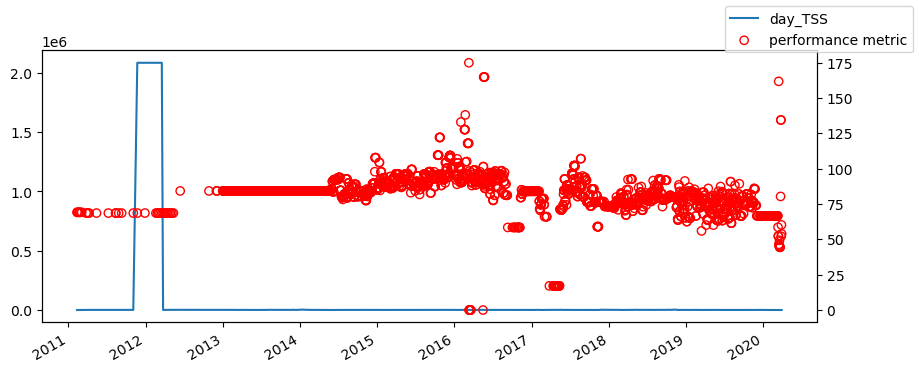

In [154]:
ctls_ref = 42
atls_ref = 7
performance_fxn = performance_fxns[0]


data_pre = ath_sum_df.copy()

data = pre_process(data_pre, performance_fxn=performance_fxn, athlete_statics=athlete_statics, sport=False).dropna()
data['performance_metric'] = np.where(data['performance_metric'] > 200, 0, data['performance_metric'])
load_metric = data['day_TSS'].to_numpy()
performance_metric = data['performance_metric'].to_numpy()
fig, ax = plt.subplots(figsize=(10,4))
data['day_TSS'].rolling(window=7,min_periods=1).sum().plot(ax=ax)
ax2 = ax.twinx()
ax2.scatter(data.index
            ,data['performance_metric']#.rolling(window=1, min_periods=1).max()
            ,marker='o'
            ,edgecolor='red'
            ,facecolor='none'
            ,label='performance metric'
            )
fig.legend()

In [155]:
data

,day_TSS,performance_metric,date
2011-02-11,186.13490,69.129502,2011-02-11
2011-02-12,185.92579,69.112734,2011-02-12
2011-02-19,201.34846,69.112734,2011-02-19
2011-02-21,168.44171,69.112734,2011-02-21
2011-02-26,202.64304,69.112734,2011-02-26
...,...,...,...
2020-03-25,46.33252,134.408938,2020-03-25
2020-03-26,95.04764,134.408938,2020-03-26
2020-03-27,23.46357,52.191989,2020-03-27
2020-03-28,44.22854,60.182141,2020-03-28


In [ ]:
data[-100:][['METRICS.average_power','METRICS.average_hr','METRICS.a_coggan_tss','METRICS.athlete_weight']]

### Model

In [85]:
bm = banister()

def optimize_banister(params):    
    losses = []

    Banister_Predictions = bm.model(load_metric, params=params)
    
    losses = abs(performance_metric - Banister_Predictions)
    MAE = np.mean(losses)
    return MAE

initial_guess  = [.5, .5, 65, 45, 7]
individual_banister_model = optimize.minimize(optimize_banister
                                            ,x0=initial_guess
                                                #     k1,       k2,       p0,     CTLS,   ATLS
                                            ,bounds=[(.10,1.00),(.10,1.0),(50,70),(30,50),(5,12)]
                                            # ,method='Nelder-Mead'
                                            # ,tol=1e-8
                                            )
print(individual_banister_model)
for val in individual_banister_model['x']:
    print(val)

      fun: 5.121697848357477
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.43677104e-02, -5.96828365e-02,  5.54578953e-04, -4.44089173e-06,
        9.71667111e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 396
      nit: 31
     njev: 66
   status: 0
  success: True
        x: array([ 0.15981847,  0.12939025, 66.53785274, 44.96458829,  8.24051045])
0.15981847385797524
0.12939025428099507
66.53785273654908
44.96458829433291
8.240510448008344


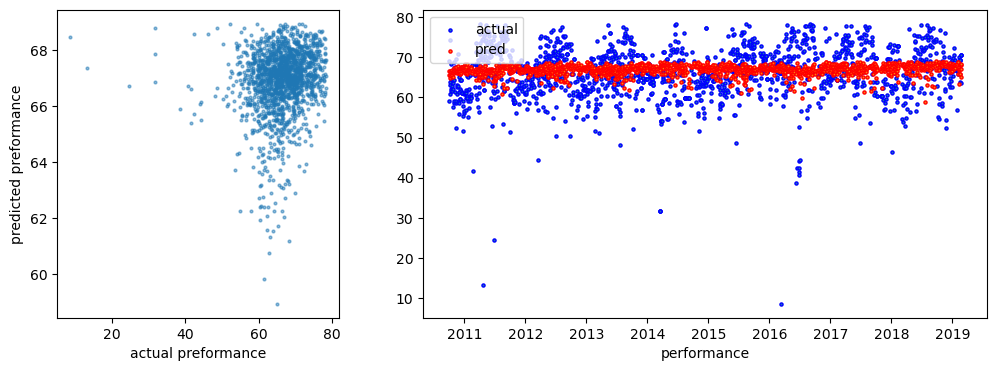

In [94]:
load_metric = data['day_TSS'].tolist()
data['pred_performance_metric'] = bm.model(load_metric)

p_data = data[(data['performance_metric']<data['performance_metric'].quantile(.95)) 
             &(data['pred_performance_metric']<data['pred_performance_metric'].quantile(.95)) ]

## Plot
fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=100,  gridspec_kw={'width_ratios': [1,2]})
ax[0].scatter(x=p_data['performance_metric']
          ,y=p_data['pred_performance_metric']
          ,s=4
          ,alpha=.5)
ax[0].set_xlabel('actual preformance')
ax[0].set_ylabel('predicted preformance')

ax[1].scatter(p_data.index
             ,p_data['performance_metric']
             ,label='actual'
             ,facecolor=None
             ,edgecolor='blue'
             ,s=5
             ,linewidths=1
             ,marker='o')
ax[1].scatter(p_data.index
             ,p_data['pred_performance_metric']
             ,label='pred'
             ,facecolor=None
             ,edgecolor='red'
             ,s=5
             ,linewidths=1
             ,marker='o')
ax[1].set_xlabel('date')
ax[1].set_xlabel('performance')
ax[1].legend(loc=2)

## Bayes Solver

In [105]:
import pymc3 as pm
from pymc3 import HalfCauchy, Model, Normal, sample, Uniform, Beta

print(f"Running on PyMC v{pm.__version__}")


You can find the C code in this temporary file: /var/folders/gn/wxd67cbn51d8ncyr2z2nkfzh0000gn/T/theano_compilation_error_s71a9qsf


AttributeError: partially initialized module 'theano' has no attribute 'gof' (most likely due to a circular import)

In [104]:
!conda uninstall theano -y

Solving environment: done

## Package Plan ##

  environment location: /Users/ryanduecker/opt/anaconda3

  removed specs:
    - theano


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cftime-1.5.1.1             |   py39h67323c0_0         182 KB
    conda-package-handling-2.0.2|   py39hecd8cb5_0         268 KB
    conda-package-streaming-0.7.0|   py39hecd8cb5_0          28 KB
    conda-repo-cli-1.0.5       |   py39hecd8cb5_0         106 KB
    dill-0.3.6                 |   py39hecd8cb5_0         167 KB
    patch-2.7.6                |    h1de35cc_1001         128 KB
    pathlib-1.0.1              |     pyhd3eb1b0_1          17 KB
    tapi-1100.0.11             |       h1527ee5_1         182 KB
    theano-pymc-1.1.2          |   py39hae1ba45_0         1.8 MB
    xarray-2022.11.0           |   py39hecd8cb5_0         1.6 MB
    zstandard-0.19.0           |   py39h6c40b1e_0         452 KB
 

In [ ]:
# data_pre = data_original[data_original['Sport'] == 'Run'].copy()
data = pre_process(data_pre, performance_fxn=performance_fxn)
    
TSS = data['day_TSS'].tolist()
performance_kpi = data['performance_metric'].tolist()

def banister_regression(TSS, performance_kpi):
    with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
        # Define priors
        sigma = Normal("sigma", 0, sigma=5)

        p0 = Normal("p0", 55, sigma=7)
        ctls_mu = Normal("ctls_mu", 42, 4)
        atls_mu = Normal("atls_mu", 7, 2)
        ctls_sigma = Normal("ctls_sigma", 8, 4)
        atls_sigma = Normal("atls_sigma", 4, 2)
        ctls = Normal("ctls", ctls_mu, sigma=ctls_sigma) #6
        atls = Normal("atls", atls_mu, sigma=atls_sigma) #2.5
        
        k1 = Beta("k1", alpha=1, beta=5) # guess == 0.1
        k2 = Beta("k2", alpha=1, beta=3) # guess == 0.5

        # Define likelihood
        banister_prediction = Normal("banister_prediction",
                                     mu=(p0 
                                         + k1 * (TSS * 1-pm.math.exp(-1/ctls))
                                         - k2 * (TSS * 1-pm.math.exp(-1/atls))
                                        )
                                    ,sigma=sigma
                                    ,observed=performance_kpi)
    return model

banister_model = banister_regression(TSS=TSS, performance_kpi=performance_kpi)
with banister_model:
    fit = pm.sample(2_000)

## NN

In [ ]:
for activ_array in all_activity_arrays:
    activ_array

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.input = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.hidden_1 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.output = nn.Linear(in_features=16, out_features=output_dim)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden_1(x))
        return self.output(x)
    
    
model = Net()
print(model)

In [ ]:
num_epochs = 200
train_accuracies, test_accuracies = [], []

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

for epoch in range(num_epochs):
    # Train set
    for X, y in train_loader:
        preds = model(X)
        pred_labels = torch.argmax(preds, axis=1)
        loss = loss_function(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_accuracies.append(
        100 * torch.mean((pred_labels == y).float()).item()
    )
    
    # Test set
    X, y = next(iter(test_loader))
    pred_labels = torch.argmax(model(X), axis=1)
    test_accuracies.append(
        100 * torch.mean((pred_labels == y).float()).item()
    )